# Mise en place des modèles de clustering

In [1]:
# Importations
import warnings
warnings.filterwarnings('ignore')
import pickle
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.model_selection import GridSearchCV
from yellowbrick.cluster import KElbowVisualizer

Dans cette section, nous allons réaliser un modèle de clustering qui réalisera une segmentation des clients basée sur la méthode RFM (Récence, Fréquence, Montant). Cette segmentation sépare les clients selon trois critères : la date de la dernière commande passée, le nombre de commandes passées et le montant total dépensé par le client. 

## Choix des variables et analyses multivariées

Commençons par charger notre dataframe. Les colonnes qui vont nous être utiles ici sont les colonnes total_spent, last_order et order_frequency.

In [2]:
df = pickle.load(open("clean_data.pkl", "rb"))
cluster_df = df[["total_spent", "last_order", "orders_frequency"]]
print(cluster_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97567 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   total_spent       97567 non-null  float64
 1   last_order        97567 non-null  int64  
 2   orders_frequency  97567 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 3.0 MB
None


D'abord, affichons une heatmap qui représente la matrice de corrélation de la dataframe afin de voir si certaines colonnes sont corrélées :

<AxesSubplot:>

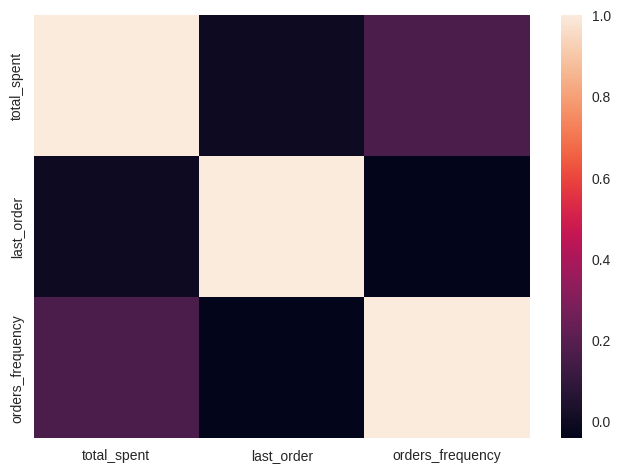

In [3]:
sns.heatmap(cluster_df.corr())

On constate que les corrélations entre nos différentes features sont faibles, voire nulles.

Avant de réaliser un clustering sur nos données, il est important de mieux les comprendre. Pour cela, nous allons réaliser un nuage de points en trois dimensions de notre dataframe en utilisant la technique du PCA (Principal Component Analysis). Cela nous permettra de mieux identifier les différents clusters potentiels dans nos données.

Pour bien voir l'intérêt du PCA, affichons d'abord nos données sans PCA :

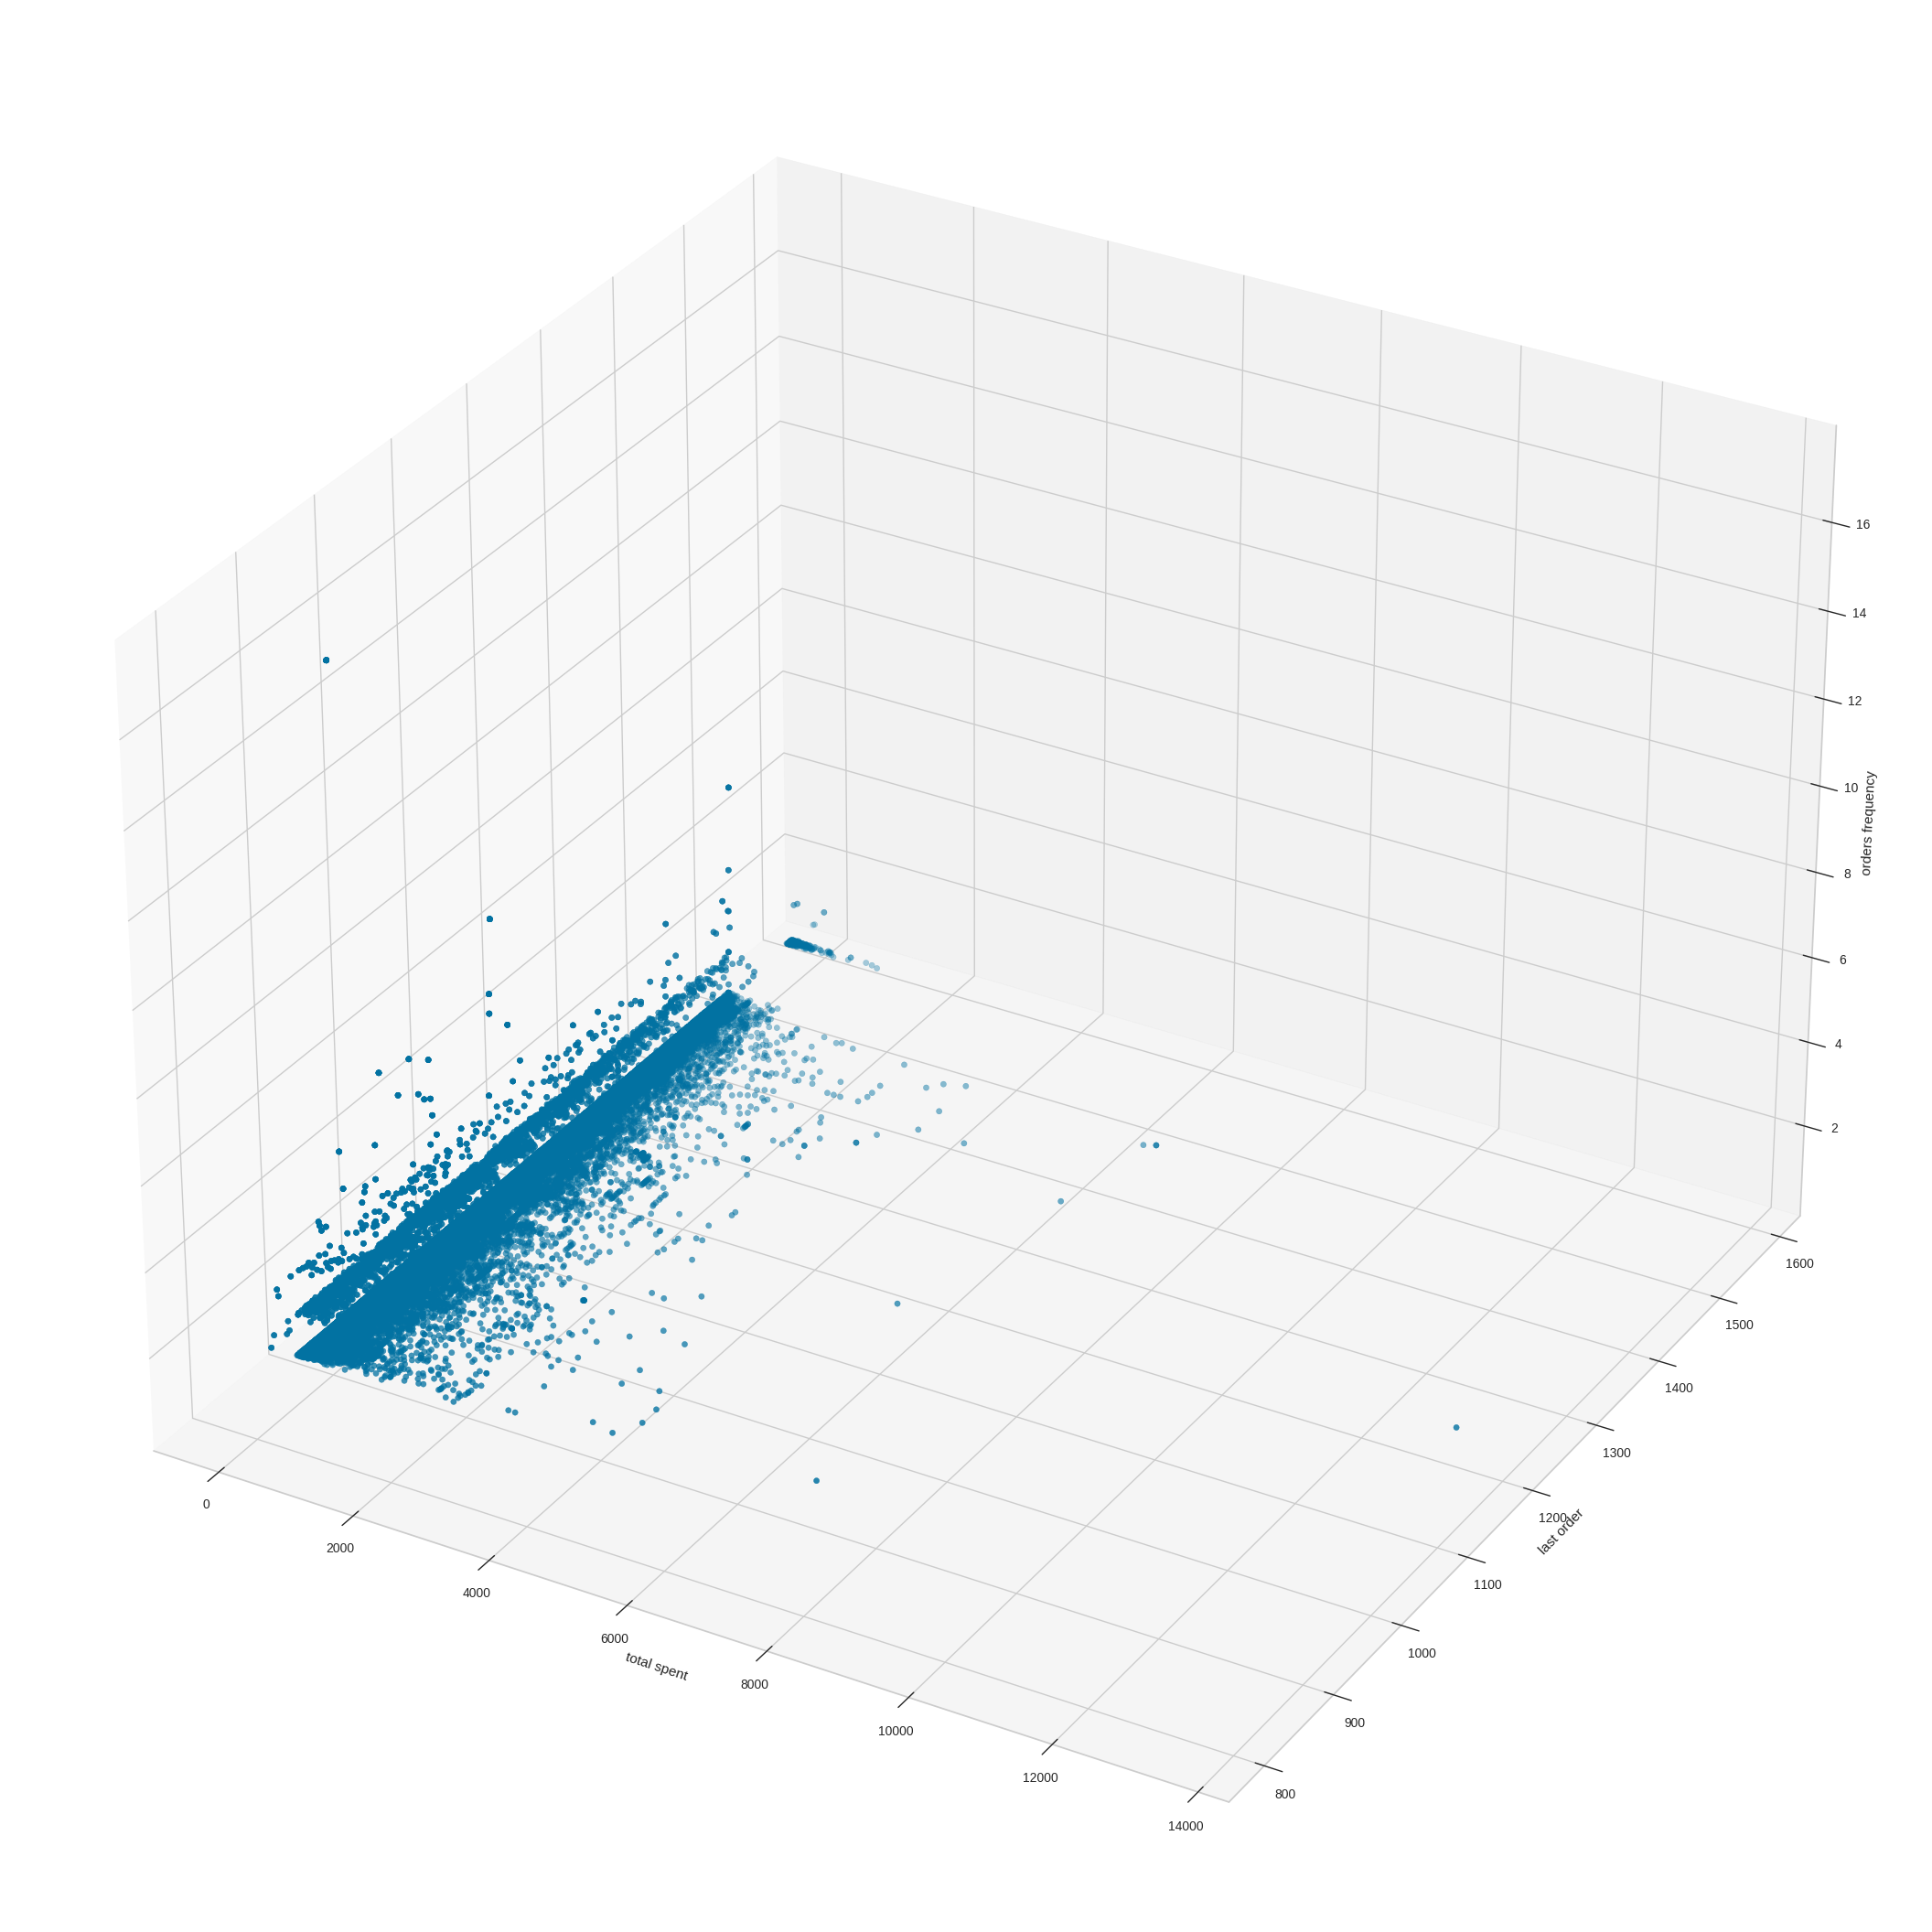

In [4]:
# Affichage du nuage de points sans PCA
fig = plt.figure()
fig.set_size_inches(27, 75)
ax = fig.add_subplot(111, projection = '3d')

x = cluster_df['total_spent']
y = cluster_df['last_order']
z = cluster_df['orders_frequency']

ax.set_xlabel("total spent")
ax.set_ylabel("last order")
ax.set_zlabel("orders frequency")

ax.scatter(x, y, z)

plt.show()

Et, maintenant, faisons la même chose en appliquant le PCA à nos données avant de les afficher :

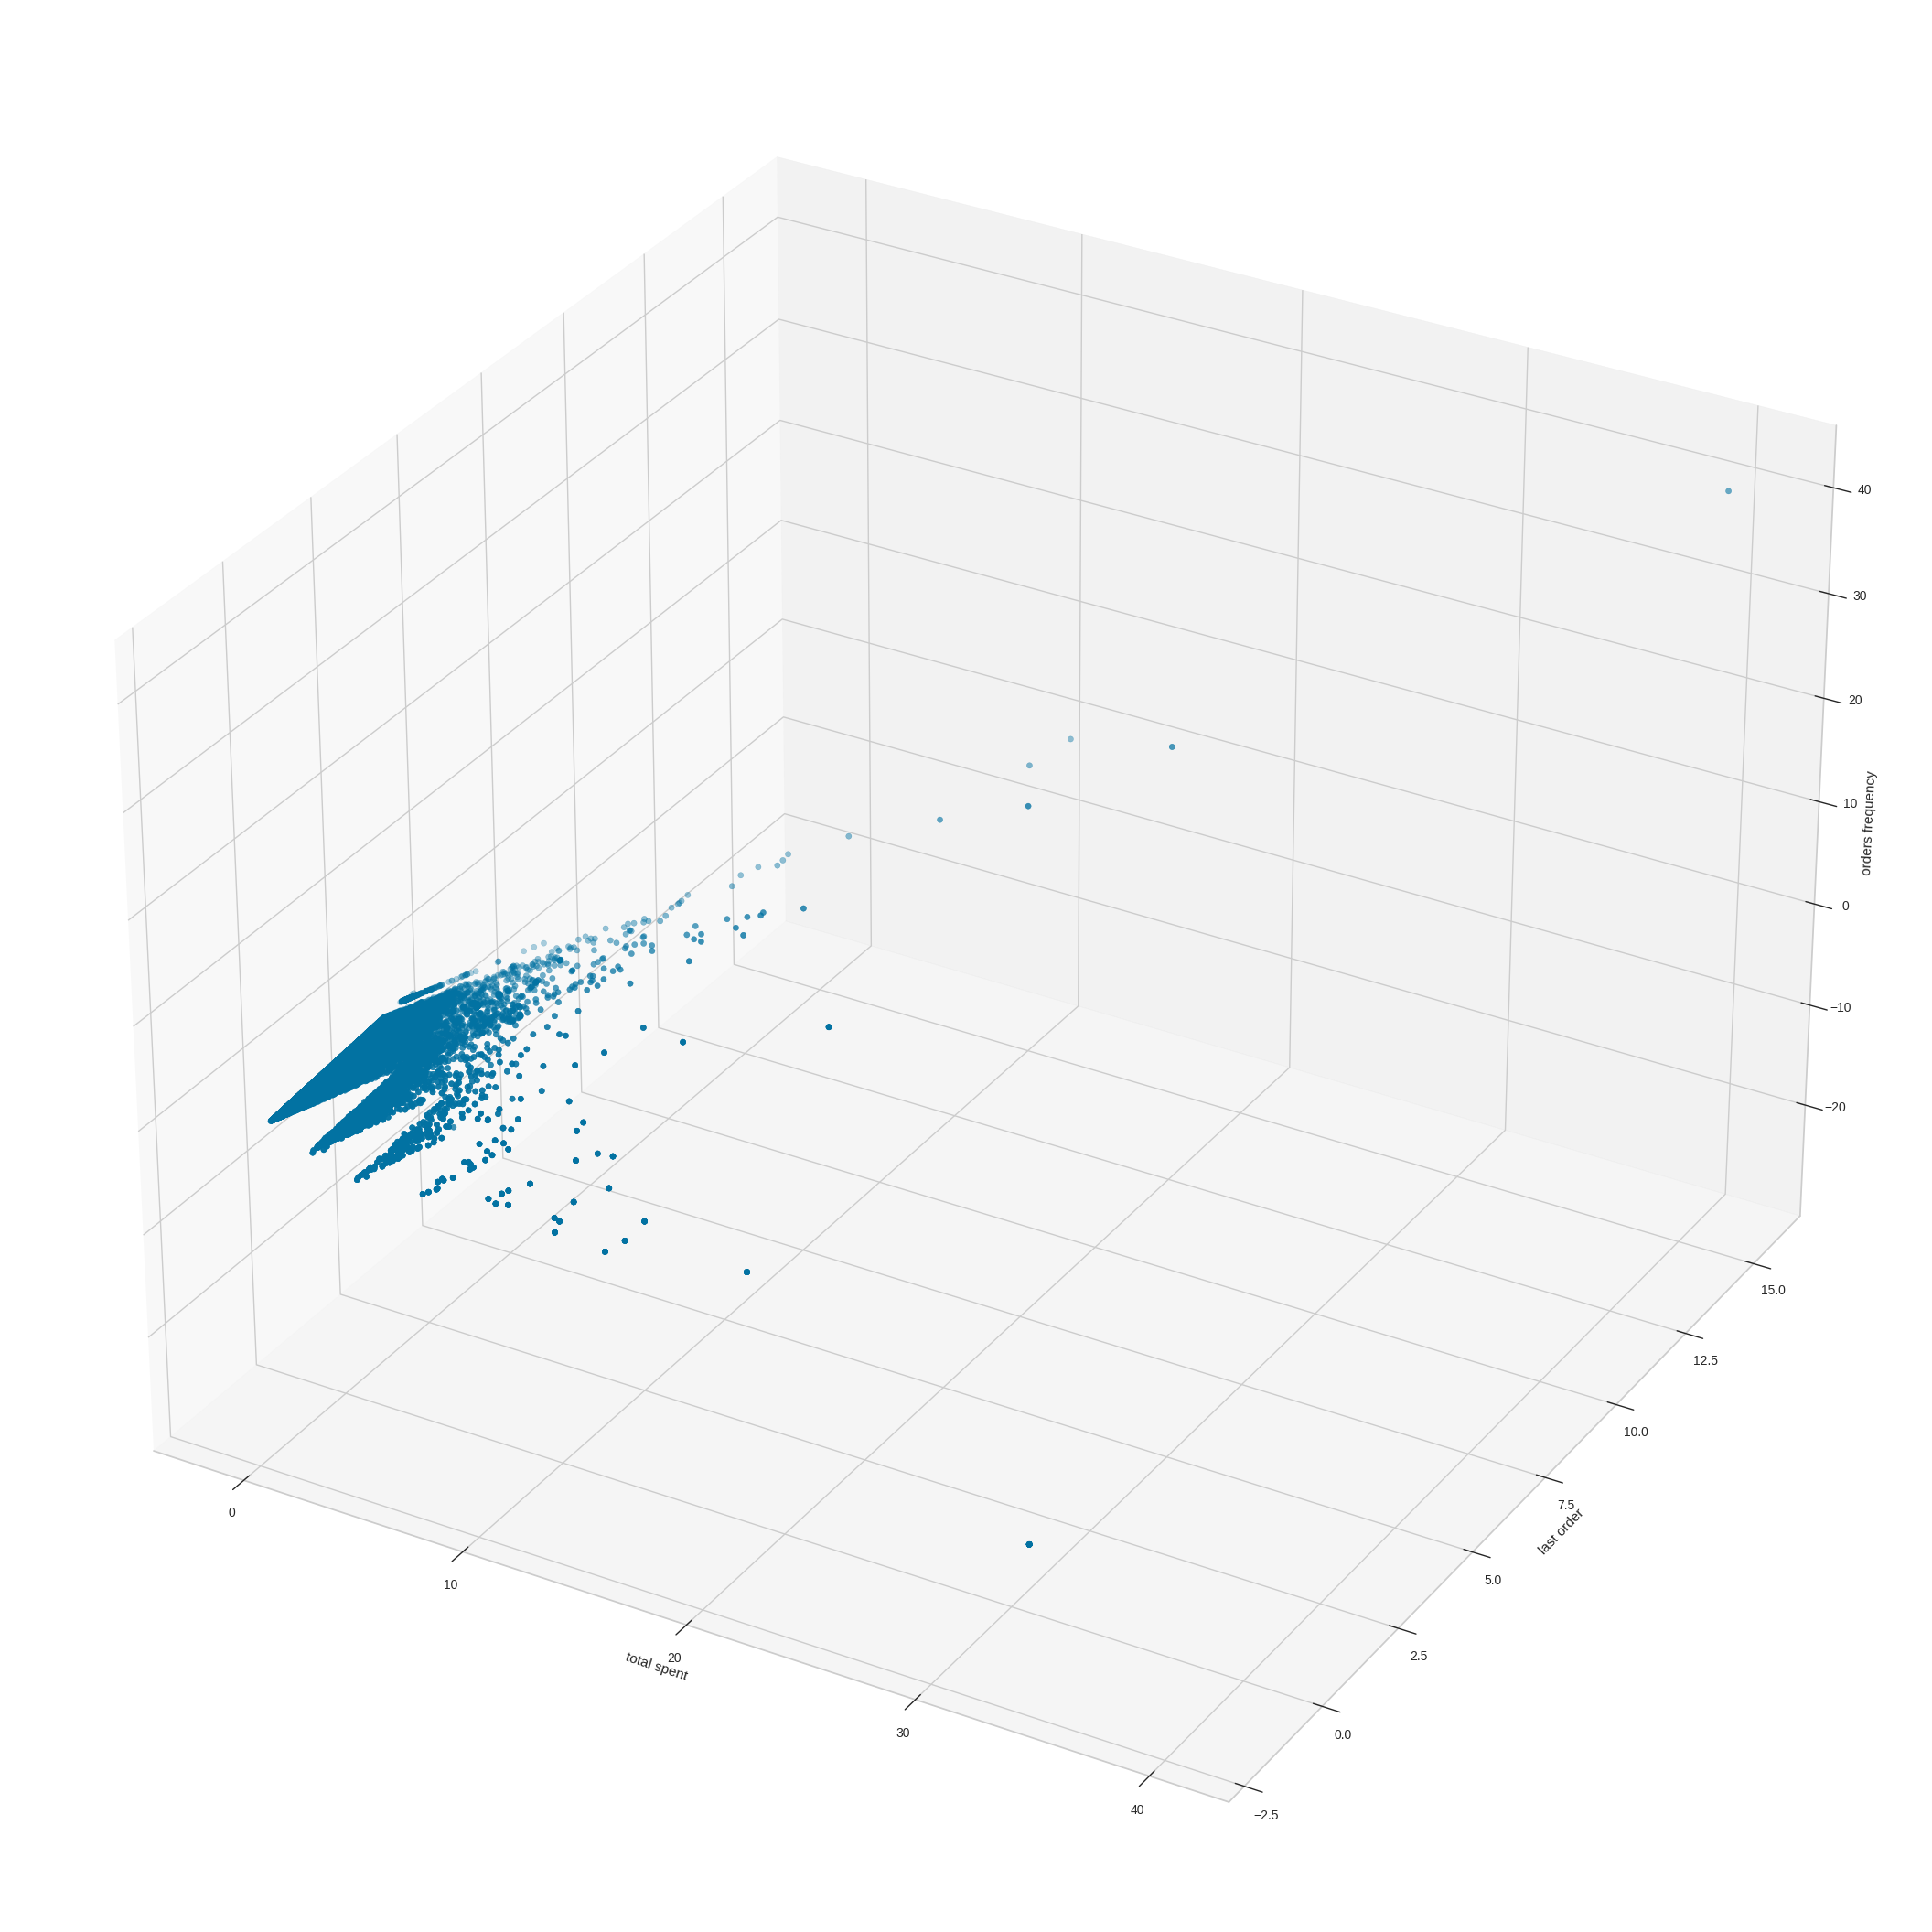

In [5]:
# Affichage du nuage de points avec PCA
pca = PCA(n_components=3)
standardized_cluster_df = StandardScaler().fit_transform(cluster_df)
pca_cluster = pd.DataFrame(pca.fit_transform(standardized_cluster_df))

fig = plt.figure()
fig.set_size_inches(27, 75)
ax = fig.add_subplot(111, projection = '3d')

x = pca_cluster[0]
y = pca_cluster[1]
z = pca_cluster[2]

ax.set_xlabel("total spent")
ax.set_ylabel("last order")
ax.set_zlabel("orders frequency")

ax.scatter(x, y, z)

plt.show()


Bien qu'aucun de ces deux nuages de points en 3D ne soit très lisible, on peut tout de même plus facilement distinguer des groupes de points dans le second graphique (après PCA).

Si l'on affiche maintenant la heatmap de nos données après y avoir appliqué le PCA, on constate qu'il n'y a plus de corrélation entre les différentes features. L'avantage du PCA est également d'éliminer ces colinéarités entre features, qui peuvent affecter la précision de notre modèle de clustering :

<AxesSubplot:>

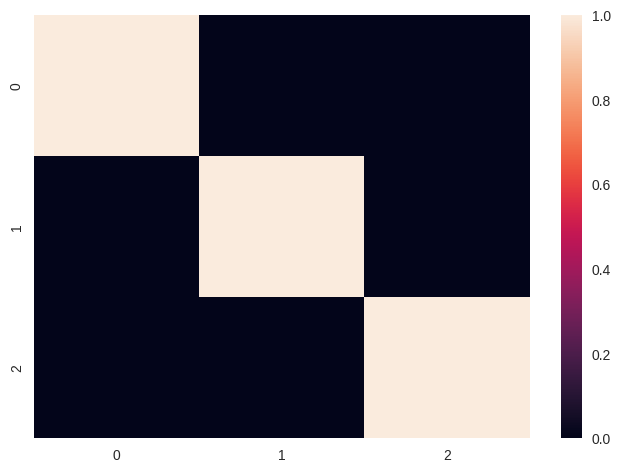

In [6]:
sns.heatmap(pca_cluster.corr())

## Clustering

### K-means

Avant de commencer à créer nos modèles de clustering, une question se pose : combien de clusters faut-il identifier ? En effet, lorsque l'on crée un modèle, il faut lui donner le nombre de clusters à créer. Pour cela, nous pouvons utiliser la méthode elbow, qui identifie le nombre optimal de clusters. Au-delà de ce nombre, on court le risque de créer trop de clusters, qui seront trop restreints individuellement.

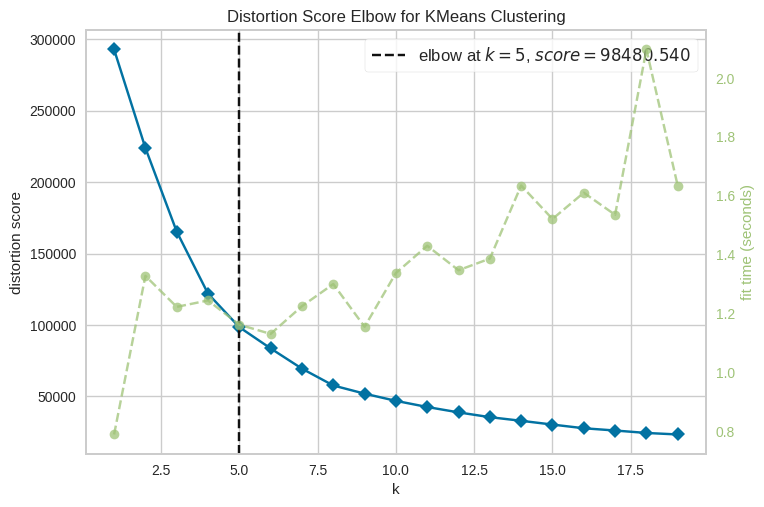

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [7]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(pca_cluster)       
visualizer.show()        

La librairie Yellowbrick, que nous avons utilisée pour générer ce graphique, nous montre le nombre de clusters optimal, 5 dans ce cas. Maintenant que nous connaissons le nombre de clusters à utiliser, nous pouvons générer notre modèle de clustering à l'aide de la méthode des k-means :

In [15]:
clusters = KMeans(n_clusters=5).fit(pca_cluster.astype(float))

Avant de tester d'autres modèles de clustering, une question se pose : comment faire pour comparer les performances de ces différents modèles ? En apprentissage supervisé, il est possible de calculer l'erreur entre les valeurs prédites et les valeurs attendues. Cependant, cela est impossible en apprentissage supervisé car nous n'avons pas de labels ici. 

Heureusement, différentes mesures de performances existent pour le clustering. Ici nous allons utiliser le coefficient de silhouette. Le coefficient de silhouette d'un point est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec les points des autres groupes voisins (séparation). Pour calculer les performances d'un modèle, on regarde la moyenne des coefficients de silhouette de tous les points :

In [10]:
# Performances du modèle :
print(metrics.silhouette_score(pca_cluster, clusters.labels_))


0.48267910565273503


Cette approche fonctionne, mais il nous a fallu attendre plusieurs minutes avant d'obtenir un résultat. Afin de gagner du temps, nous utiliserons plutôt, pour comparer les performances de nos modèles, l'indice de Calinski-Harabasz. Cet indice se définit comme le rapport entre la variance inter-groupes et la variance intra-groupe. Plus il est élevé, plus notre modèle est efficace.

In [11]:
print("Indice de performances pour le modèle des K-means : ", 
      metrics.calinski_harabasz_score(pca_cluster, clusters.labels_))

Indice de performances pour le modèle des K-means :  47994.160061160925


Cette fois, il ne nous aura fallu qu'une fraction de secondes pour avoir un résultat ; gardons donc cette mesure de performances dans la suite de ce notebook.

### Classification ascendante hiérarchique (CAH)

La classification ascendante hiérarchique est une technique de clustering. Dans cette approche, on part d'une situation où il y a autant de clusters que de points (chaque point représente une classe à lui seul). L'algorithme regroupe ensuite les classes les plus similaires entre elles jusqu'à obtenir le nombre de clusters que l'on veut avoir.

Comme pour les k-means, commençons par définir le nombre de classes optimales :

In [12]:
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(pca_cluster)       
visualizer.show()       

MemoryError: Unable to allocate 35.5 GiB for an array with shape (4759610961,) and data type float64

Lorsque l'on essaie d'exécuter ce code, on rencontre une erreur. Visiblement, le clustering CAH est TRÈS gourmand en mémoire (35,5 Go de mémoire sont requis dans ce cas !).

Pour pallier à ce problème nous n'avons pas de solution miracle, si ce n'est de calculer le nombre de clusters optimal à partir d'un échantillon de données uniquement :

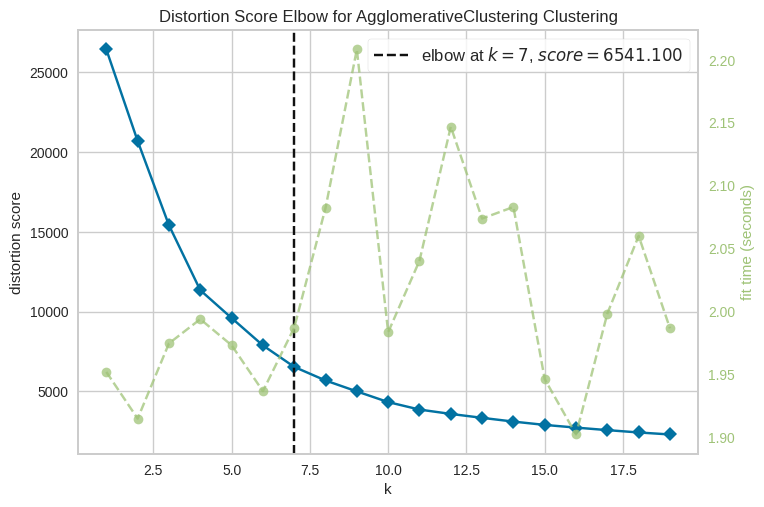

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
sample = pca_cluster.sample(frac=0.1)
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(sample)       
visualizer.show()    

Ici, 6 semble être le nombre de clusters optimal. Nous pouvons maintenant créer et entraîner notre modèle CAH en lui donnant notre échantillon de données 'sample' (et non pas la totalité des données !). Calculons aussi les performances du modèle dans la foulée :

In [14]:
clusters = AgglomerativeClustering(n_clusters=6).fit(sample.astype(float))
print("Indice de performances pour le modèle de la classification ascendante hiérarchique : ", 
      metrics.calinski_harabasz_score(sample, clusters.labels_))



Indice de performances pour le modèle de la classification ascendante hiérarchique :  4587.463282380005


On constate que ce modèle offre des performances nettement inférieures à la méthode des K-means dans notre cas.

### DBSCAN

Essayons maintenant DBSCAN, un algorithme qui se base sur la mesure de la densité de chaque cluster pour définir ces derniers. Contrairement aux algorithmes présentés précédemment, celui-ci ne nécessite pas de connaître à l'avance le nombre de cluster : c'est lui qui va en estimer automatiquement le nombre.

Ce modèle prend un hyperparamètre epsilon : ici, nous allons essayer différentes valeurs pour cet hyperparamètre et prendre en compte le meilleur score réalisé par le modèle. Comme cela représente une grosse charge de calcul pour l'ordinateur, nous allons réaliser l'entraînement avec un échantillon de données limité.

In [ ]:
# On entraîne notre modèle avec différentes valeurs eps. Ces valeurs correspondent
# à l'hyperparamètre epsilon de DBSCAN. On gardera la meilleure mesure de performances
# dans la liste qui s'affichera à l'écran
# ATTENTION : L'EXÉCUTION DE CETTE CELLULE PEUT PRENDRE BEAUCOUP DE TEMPS !
eps_parameters = [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 5, 10]
sample = pca_cluster.sample(frac=0.1)
for eps in eps_parameters:
    clusters = DBSCAN(eps=eps).fit(sample.astype(float))
    print(f"Indice de performances pour le modèle DBSCAN avec eps = : {eps}", 
          metrics.calinski_harabasz_score(sample, clusters.labels_))

5 semble être une bonne valeur pour le paramètre epsilon. Essayons d'entraîner le modèle avec cette valeur en utilisant cette fois plus de données (mais pas la totalité : cela représenterait une charge de calcul trop importante) :

In [ ]:
# ATTENTION : L'EXÉCUTION DE CETTE CELLULE PEUT PRENDRE BEAUCOUP DE TEMPS !
sample = pca_cluster.sample(frac=0.2)
clusters = DBSCAN(eps=5).fit(sample.astype(float))
print("Indice de performances pour le modèle DBSCAN : ", 
      metrics.calinski_harabasz_score(sample, clusters.labels_))

Là encore, ce modèle offre des performances significativement inférieures à celles des K-means.

### OPTICS

OPTICS est une version plus évoluée de DBSCAN. Il peut notamment détecter des clusters de densités différentes, et se prête mieux à des calculs sur de grands ensembles de données, selon la documentation de Scikit-learn. Il utilise un hyperparamètre nommé xi.

In [ ]:
# ATTENTION : L'EXÉCUTION DE CETTE CELLULE PEUT PRENDRE BEAUCOUP DE TEMPS !
xi_parameters = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.4, 0.6, 0.8]
sample = pca_cluster.sample(frac=0.1)
for xi in xi_parameters:
    clusters = OPTICS(xi=xi).fit(sample.astype(float))
    print(f"Indice de performances pour le modèle OPTICS avec xi = : {xi}", 
          metrics.calinski_harabasz_score(sample, clusters.labels_))
    
sample = pca_cluster.sample(frac=0.2)
clusters = OPTICS().fit(sample.astype(float))
print("Indice de performances pour le modèle OPTICS : ", 
      metrics.calinski_harabasz_score(sample, clusters.labels_))

Les performances de ce modèle sont les plus faibles des quatre modèles que nous avons testés.

### Choix du modèle et interprétation des résultats

Parmi ces quatre modèles, le plus performant est donc celui basé sur les K-means. Visualisons les clusters obtenus par le biais de ce modèle :

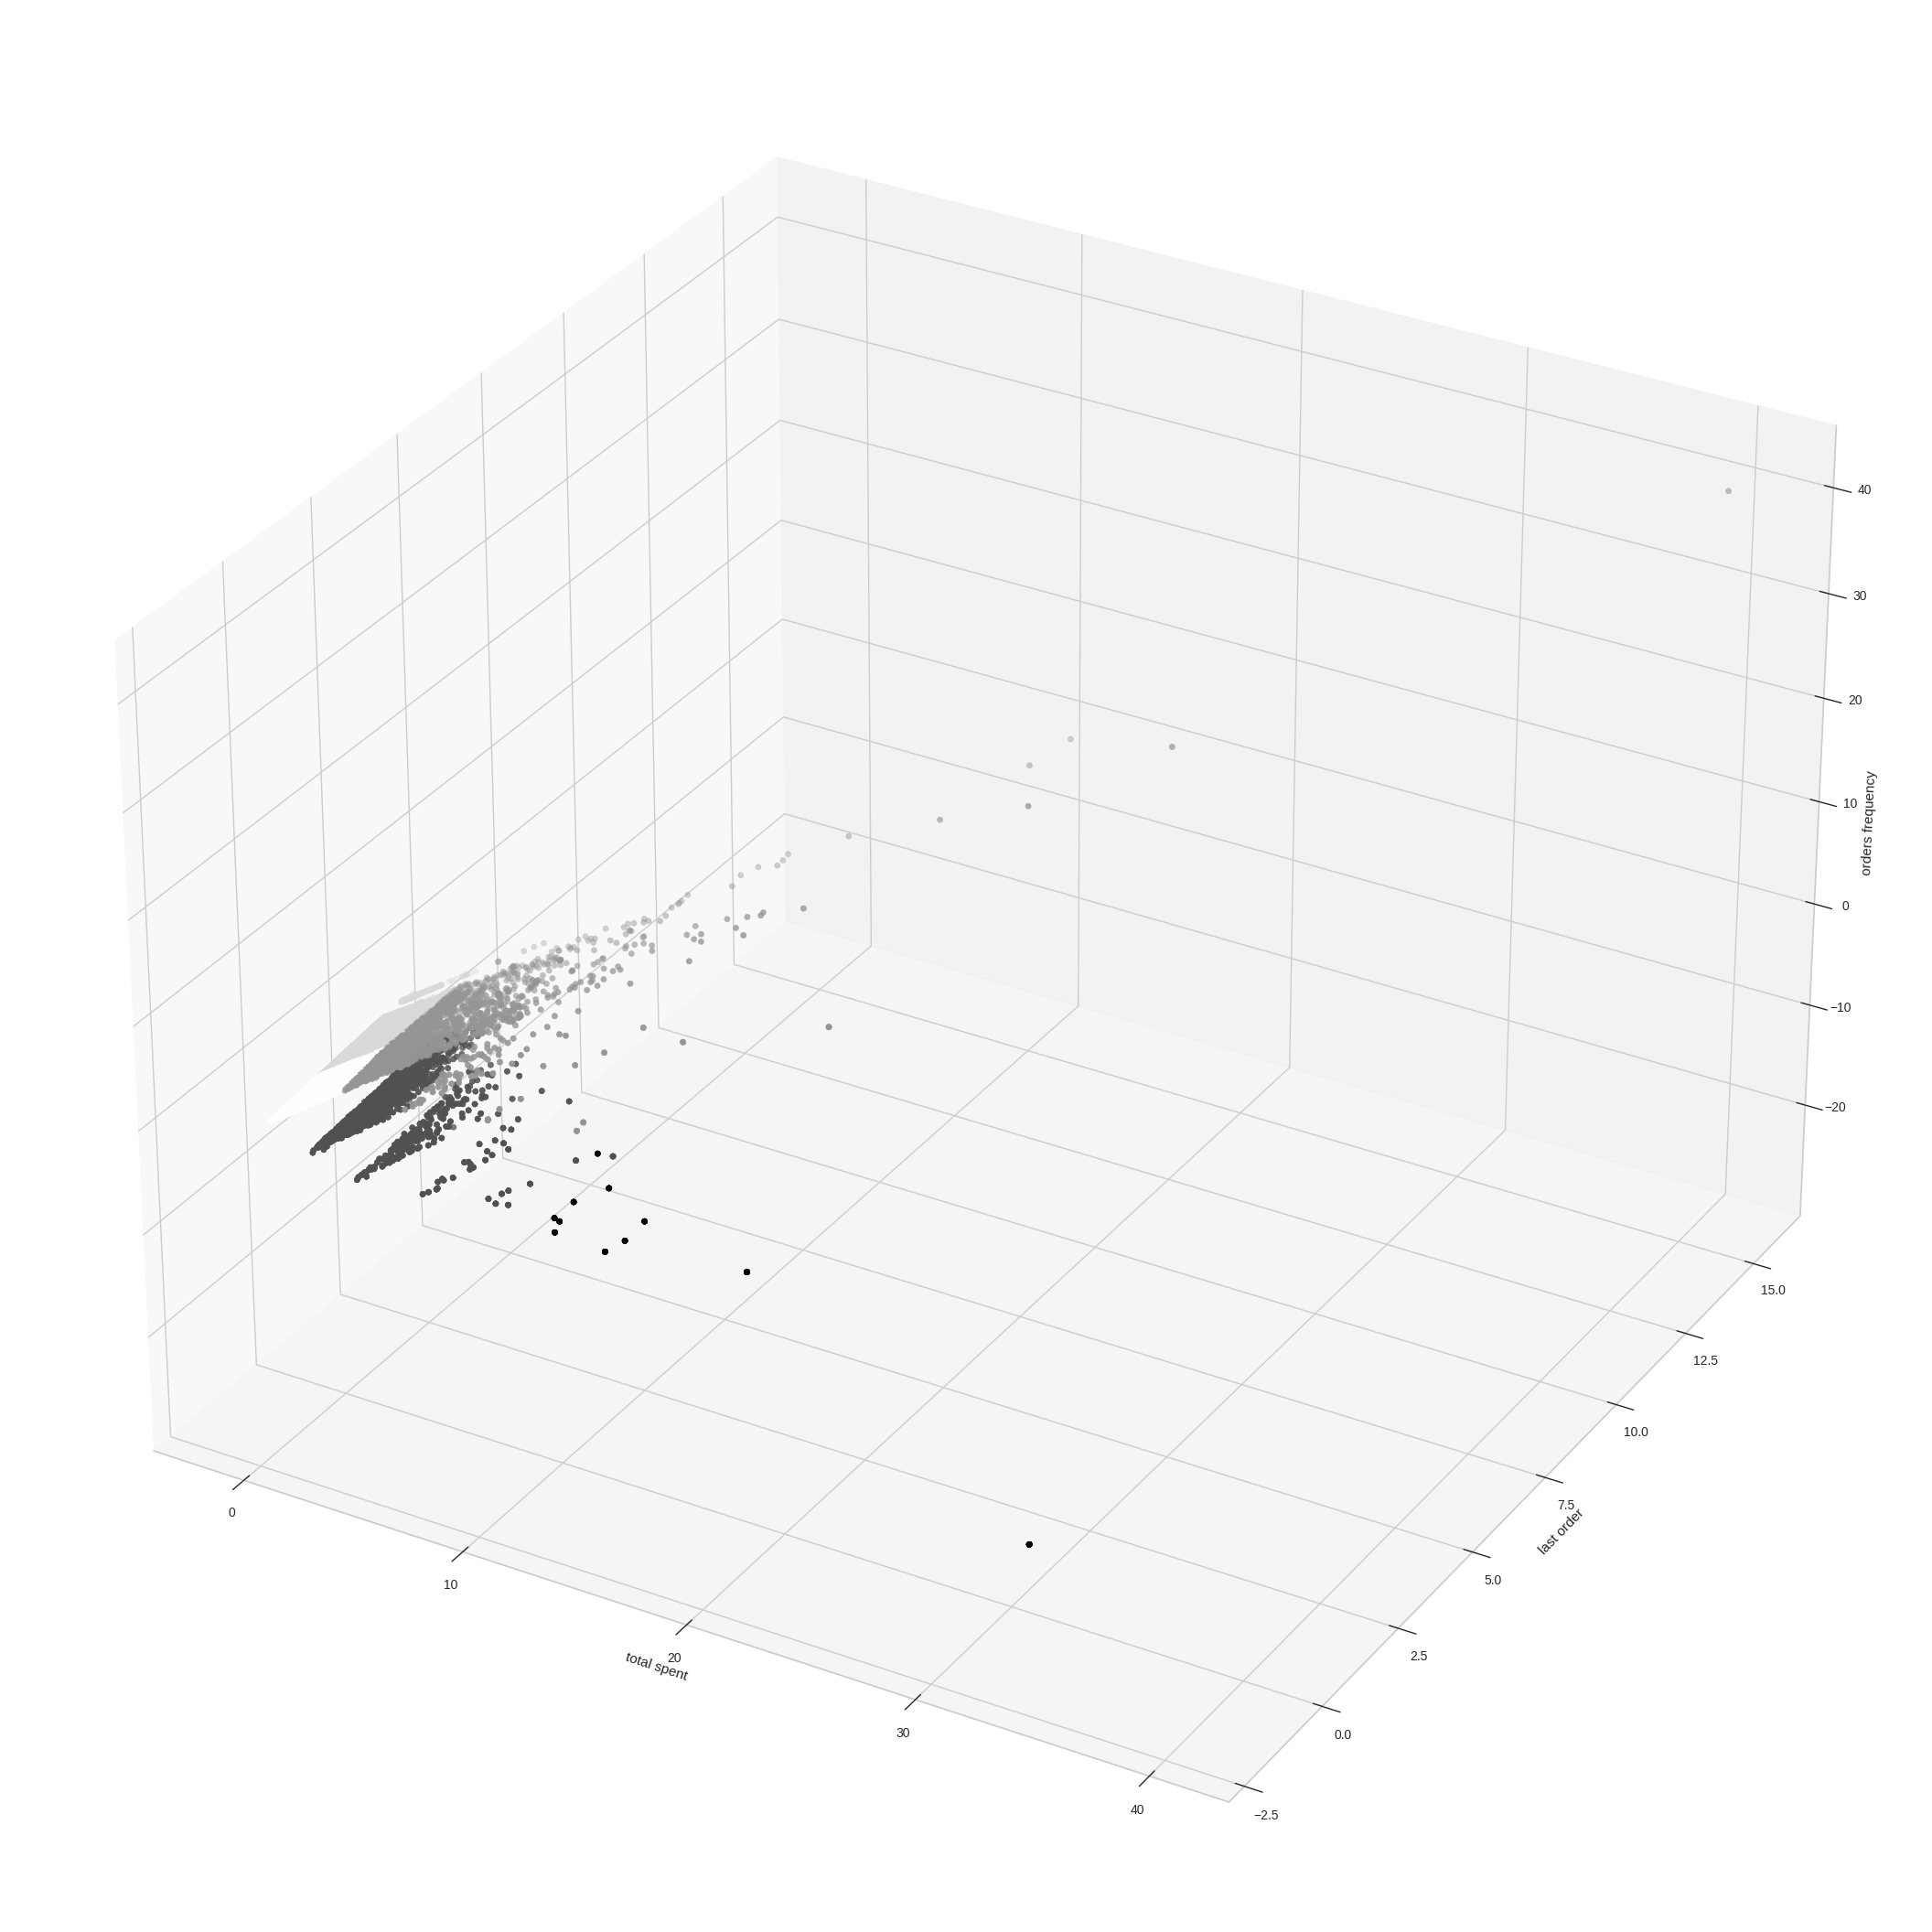

In [8]:
clusters = KMeans(n_clusters=5).fit(pca_cluster.astype(float))

fig = plt.figure()
fig.set_size_inches(27, 75)
ax = fig.add_subplot(111, projection = '3d')

x = pca_cluster[0]
y = pca_cluster[1]
z = pca_cluster[2]

ax.set_xlabel("total spent")
ax.set_ylabel("last order")
ax.set_zlabel("orders frequency")

ax.scatter(x, y, z, c=clusters.labels_.astype(float))

plt.show()


Le nuage de points 3D obtenu n'est pas très lisible. Un bon moyen de mieux visualiser les différences entre chaque cluster obtenu est de dessiner un graphique en toile d'araignée où chaque axe correspond à une feature. Nous afficherons aussi les valeurs moyennes des features pour chaque cluster :

In [9]:
k_means_cluster_df = pd.DataFrame(cluster_df)
k_means_cluster_df["cluster"] = clusters.labels_.astype(int)
# On calcule la moyenne de chaque feature à l'intérieur de chaque catégorie
categories_df = k_means_cluster_df.groupby(["cluster"]).mean()
print(categories_df)
# On normalise ensuite toutes les valeurs de la dataframe pour avoir une
# échelle cohérente dans notre graphique
categories_df = (categories_df-categories_df.mean())/categories_df.std()
categories_df.reset_index(inplace=True)
print(categories_df)
melted_df = pd.melt(categories_df, id_vars=['cluster'], var_name='feature', value_name='data',
             value_vars=['total_spent', 'last_order', 'orders_frequency'])

fig = px.line_polar(melted_df, r="data", theta="feature", color="cluster", line_close=True)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()



         total_spent   last_order  orders_frequency
cluster                                            
0         114.332141   982.363153          1.000000
1         115.405073  1242.693851          1.000000
2        1191.726634  1088.456992          1.114689
3         226.000095  1073.191813          2.152548
4         673.389036   997.987952          8.831325
   cluster  total_spent  last_order  orders_frequency
0        0    -0.748474   -0.914305         -0.535938
1        1    -0.746178    1.602429         -0.535938
2        2     1.556595    0.111352         -0.502160
3        3    -0.509562   -0.036223         -0.196492
4        4     0.447620   -0.763253          1.770527


Les tableaux et le graphique ci-dessus nous permettent de mettre en évidence plusieurs éléments : 
- les clients qui font partie du groupe 2 dépensent nettement plus d'argent que les autres groupes (environ 1200 dollars au total par client en moyenne). Une attention toute particulière devrait donc être prêtée aux clients assignés à ce groupe par le modèle
- Les clients du groupe 4 présentent aussi un intérêt. Ils passent commande beaucoup plus fréquemment que les autres clients et dépensent aussi beaucoup globalement (730 dollars en moyenne)
- Les clients des groupes 0, 1 et 3 ne présentent qu'un intérêt limité dans la mesure où ils dépensent relativement peu comparé aux autres.